In [1]:
import os
import boto3
import lz4.frame
import pandas as pd
import json
from botocore import UNSIGNED
from botocore.config import Config
from datetime import datetime


def get_best_bid_ask(bucket_name, date, hour, symbol, fast_mode=False):
    """
    Retrieve best bid and ask data for a given symbol, date, and hour from S3 or local storage.
    If the file already exists locally, load it from there. Otherwise, download, process, and save it.

    Args:
        bucket_name (str): S3 bucket name.
        date (str): Date in 'YYYYMMDD' format.
        hour (str or int): Hour of the day (0-23).
        symbol (str): Symbol name (e.g., 'SOL').

    Returns:
        pd.DataFrame: DataFrame containing best bid and ask per timestamp.
    """
    # Define local storage path
    local_dir = os.path.join("hl_data", date, str(hour))
    local_file = os.path.join(local_dir, f"{symbol}.parquet")

    # Create directory if it does not exist
    os.makedirs(local_dir, exist_ok=True)

    # Check if the file exists locally
    if os.path.exists(local_file):
        # print(f"Loading data from local file: {local_file}")
        return pd.read_parquet(local_file)

    if fast_mode == True:
        # print(f"File Not Found for {symbol}, fast mode, skipping.")
        return pd.DataFrame()
    else:
        print(f"Local file not found. Downloading from S3...")
    
    # S3 key for the specified file
    s3_key = f"market_data/{date}/{hour}/l2Book/{symbol}.lz4"
    print(f"Downloading {s3_key} from bucket {bucket_name}...")

    # Initialize S3 client (public bucket access)
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

    try:
        # Download file to memory
        response = s3.get_object(Bucket=bucket_name, Key=s3_key)
        compressed_data = response['Body'].read()

        # Decompress data using lz4
        decompressed_data = lz4.frame.decompress(compressed_data)

        # Parse JSON lines and extract data
        rows = []
        for line in decompressed_data.decode('utf-8').splitlines():
            if not line.strip():
                continue

            # Parse JSON line
            data = json.loads(line)
            timestamp = data['time']
            coin = data['raw']['data']['coin']
            levels = data['raw']['data']['levels']

            # Extract bid and ask levels
            for side, side_name in zip(levels, ['bid', 'ask']):
                for level in side:
                    rows.append({
                        'timestamp': timestamp,
                        'coin': coin,
                        'price': float(level['px']),
                        'size': float(level['sz']),
                        'num_orders': level['n'],
                        'side': side_name
                    })

        # Create DataFrame
        df = pd.DataFrame(rows)

        # Calculate Best Bid and Best Ask per timestamp
        # Extract best bid prices (highest prices for bids)
        best_bid = (
            df[df['side'] == 'bid']
            .groupby(['timestamp', 'coin'])
            .apply(lambda x: x.loc[x['price'].idxmax()])
            .reset_index(drop=True)
        )

        # Extract best ask prices (lowest prices for asks)
        best_ask = (
            df[df['side'] == 'ask']
            .groupby(['timestamp', 'coin'])
            .apply(lambda x: x.loc[x['price'].idxmin()])
            .reset_index(drop=True)
        )

        # Combine the best bid and ask into a single DataFrame
        best_prices = pd.merge(best_bid, best_ask, on=['timestamp', 'coin'], suffixes=('_bid', '_ask'))

        # Save to local file as Parquet
        print(f"Saving processed data to local file: {local_file}")
        best_prices.to_parquet(local_file, index=False)

        return best_prices

    except Exception as e:
        print(f"Error retrieving or processing data for {symbol}: {e}")
        return pd.DataFrame()

def get_last_best_bid_ask(date, symbols, fast_mode=False):
    """
    Fetch the last best bid and ask prices for each symbol on a specific date and hour (hour 23).
    
    Args:
        date (str): Date for which to retrieve data (YYYYMMDD).
        symbols (list): List of symbols to fetch data for.

    Returns:
        dict: A dictionary where keys are symbols and values contain the best bid/ask prices.
    """
    bucket_name = "hyperliquid-archive"
    result = {}
    hour = 22  # Specify the target hour
    
    for symbol in symbols:
        try:
            # Fetch the DataFrame for the symbol at the given date and hour
            df = get_best_bid_ask(bucket_name, date, hour, symbol, fast_mode)

            if len(df) == 0:
                continue
            
            # Ensure timestamp is sorted
            df = df.sort_values(by='timestamp')
            
            # Get the last row (last observation of the hour)
            last_row = df.iloc[-1]
            
            # Extract relevant prices
            best_bid = last_row['price_bid']
            best_ask = last_row['price_ask']
            
            # Add to the result dictionary
            result[symbol] = {
                'best_bid': best_bid,
                'best_ask': best_ask,
                'mid_price': (best_bid + best_ask) / 2.0
            }
        except Exception as e:
            # Log errors for missing or failed data retrieval
            print(f"Error fetching data for {symbol}: {e}")
            # result[symbol] = {'best_bid': None, 'best_ask': None}
    
    return result

# Example usage
bucket_name = "hyperliquid-archive"
date = "20240916"
hour = 9
symbol = "SOL"

# Retrieve best bid/ask data
best_bid_ask_df = get_best_bid_ask(bucket_name, date, hour, symbol)

# Show results
print(best_bid_ask_df)


                          timestamp coin  price_bid  size_bid  num_orders_bid  \
0     2024-09-16T09:00:02.356234741  SOL     131.71      9.76               1   
1     2024-09-16T09:00:02.811489572  SOL     131.70     18.98               1   
2     2024-09-16T09:00:02.829211015  SOL     131.70     18.98               1   
3     2024-09-16T09:00:02.993025514  SOL     131.71     75.92               1   
4     2024-09-16T09:00:03.598159122  SOL     131.71     25.00               1   
...                             ...  ...        ...       ...             ...   
6295  2024-09-16T09:59:57.120830036  SOL     130.91    379.27               6   
6296  2024-09-16T09:59:57.688686944  SOL     130.91    379.27               6   
6297  2024-09-16T09:59:58.290446191  SOL     130.91    477.58               9   
6298  2024-09-16T09:59:58.895925229  SOL     130.91    974.87              17   
6299  2024-09-16T09:59:59.500199861  SOL     130.93     38.18               1   

     side_bid  price_ask  s

In [2]:
# from abc import ABC, abstractmethod
from numerapi import CryptoAPI
import pandas as pd
import numpy as np
from datetime import datetime, timezone, date, timedelta

import json
import os
import requests
from websocket import create_connection

import eth_account
from eth_account.signers.local import LocalAccount

from hyperliquid.exchange import Exchange
from hyperliquid.info import Info
from hyperliquid.utils.constants import MAINNET_API_URL, TESTNET_API_URL

from oracle_interfaces import OracleInterface, NumeraiTBNOracle
from dex_interfaces import DEXInterface, HyperLiquidDEX

from scipy.optimize import minimize

# Portfolio Class to Track Cash and Positions
class Portfolio:
    def __init__(self, initial_cash=1.0, symbols=None):
        self.cash = initial_cash  # Starting cash
        self.positions = {symbol: 0.0 for symbol in (symbols or [])}  # Shares
        self.history = []  # Track portfolio changes for reporting
        self.market_prices = {}

    def set_prices(self, market_prices):
        for symbol in market_prices.keys():
            self.market_prices[ symbol ] = market_prices[symbol]['mid_price']

    def net_liquidity(self):
        """Calculate net liquidity based on current market prices."""
        total_value = self.cash
        for symbol, shares in self.positions.items():
            if abs( shares ) > 0:
                total_value += shares * self.market_prices[symbol]
        return total_value

    def transact(self, symbol, shares, price, dat):
        """Make a transaction: buy or sell shares at given price."""
        tx_amount = shares * price
        self.cash -= tx_amount
        self.positions[symbol] += shares
        self.record_transaction(symbol, shares, price, dat)

    def record_transaction(self, symbol, shares, price, dat):
        """Log transactions for debugging or reporting."""
        self.history.append({
            "timestamp": dat,
            "symbol": symbol,
            "shares": shares,
            "price": price
        })


# Backtest Function
def run_backtest(dates, oracle, dex, initial_cash=1.0, fast_mode=False, lags=25):
    tradable_universe = dex.get_universe()
    portfolio = Portfolio(initial_cash=initial_cash, symbols=tradable_universe)
    net_liqs = {}
    risks = {'meta_model':{}, 'dollars':{}}
    market_prices = {}

    for dat in dates:
        print(f"Processing {dat}...")

        # Get Market Data
        new_market_prices = get_last_best_bid_ask(dat, tradable_universe, fast_mode)  # Function defined earlier
        for symbol in new_market_prices:
            market_prices[ symbol ] = new_market_prices[ symbol ]

        print( "Loaded ", len( os.listdir(f'hl_data/{dat}/22') ), " asset for date ", dat )
        
        portfolio.set_prices(market_prices)
        
        # Get Oracle Weights
        oracle_weights = oracle.fetch_portfolio_weights(datetime.strptime(dat, "%Y%m%d"), list( market_prices.keys() ), lags)
        if oracle.validate_weights( oracle_weights ) == False:
            return

        #Get Risk Model
        risk = oracle.get_risk_for_date( datetime.strptime(dat, "%Y%m%d"), list( market_prices.keys() ) )
        # print(risk)
        # print(oracle_weights)
        

        net_liq = portfolio.net_liquidity()
        print(f"Net Liquidity: ${net_liq:.6f}")
        net_liqs[datetime.strptime(dat, "%Y%m%d")] = net_liq

        # Rebalance Portfolio to Match Oracle Weights
        for symbol in oracle_weights.keys():
            desired_dollar_weight = oracle_weights.get(symbol, 0) * net_liq
            current_dollar_weight = portfolio.positions[symbol] * market_prices[symbol]['mid_price']
            
            desired_shares = (desired_dollar_weight - current_dollar_weight) / market_prices[symbol]['mid_price']
            if desired_shares > 0:
                portfolio.transact(symbol, desired_shares, market_prices[symbol]['best_ask'], dat)
            else:
                portfolio.transact(symbol, desired_shares, market_prices[symbol]['best_bid'], dat)

        # Zero Out Positions Not in Oracle Portfolio
        for symbol, shares in portfolio.positions.items():
            if shares != 0 and symbol not in oracle_weights:
                desired_shares = -shares
                if desired_shares > 0:
                    portfolio.transact(symbol, desired_shares, market_prices[symbol]['best_ask'], dat)
                else:
                    portfolio.transact(symbol, desired_shares, market_prices[symbol]['best_bid'],dat)

        risks['meta_model'][datetime.strptime(dat, "%Y%m%d")] = ( pd.Series(risk['meta_model']) * ( pd.Series(portfolio.positions) * pd.Series(portfolio.market_prices) ) ).sum()
        risks['dollars'][datetime.strptime(dat, "%Y%m%d")] = ( pd.Series(portfolio.positions) * pd.Series(portfolio.market_prices) ).sum()
        # print( ( pd.Series(risk['meta_model']),  pd.Series(portfolio.positions) ) )
        print( "Meta Model Exposure: ", risks['meta_model'][datetime.strptime(dat, "%Y%m%d")] )
        print( "Dollar Exposure: ", risks['dollars'][datetime.strptime(dat, "%Y%m%d")] )
        print( "Oracle Dollar Exposure: ", pd.Series(oracle_weights).sum() )

    print("Backtest Completed")
    return portfolio, net_liqs, risks

# Example Backtest Run

# Generate weekdays in YYYYMMDD format
# Define the start and end dates
start_date = date(2024, 6, 1)
end_date = date(2024, 12, 10)

# Generate all weekdays as strings in 'YYYYMMDD' format
dates = [
    (start_date + timedelta(days=i)).strftime("%Y%m%d")
    for i in range((end_date - start_date).days + 1)
    if (start_date + timedelta(days=i)).weekday() < 5
]

print(dates)



['20240603', '20240604', '20240605', '20240606', '20240607', '20240610', '20240611', '20240612', '20240613', '20240614', '20240617', '20240618', '20240619', '20240620', '20240621', '20240624', '20240625', '20240626', '20240627', '20240628', '20240701', '20240702', '20240703', '20240704', '20240705', '20240708', '20240709', '20240710', '20240711', '20240712', '20240715', '20240716', '20240717', '20240718', '20240719', '20240722', '20240723', '20240724', '20240725', '20240726', '20240729', '20240730', '20240731', '20240801', '20240802', '20240805', '20240806', '20240807', '20240808', '20240809', '20240812', '20240813', '20240814', '20240815', '20240816', '20240819', '20240820', '20240821', '20240822', '20240823', '20240826', '20240827', '20240828', '20240829', '20240830', '20240902', '20240903', '20240904', '20240905', '20240906', '20240909', '20240910', '20240911', '20240912', '20240913', '20240916', '20240917', '20240918', '20240919', '20240920', '20240923', '20240924', '20240925', '20

In [14]:
oracle = NumeraiTBNOracle(tb=3)
dex = HyperLiquidDEX("mainnet")

#Turn off fast mode the first time, to grab the data from hyperliquid S3 bucket and save locally
#after saving the first time, turn on fast mode to only read from local files

portfolio_result, net_liqs, risks = run_backtest(dates, oracle, dex, fast_mode=True, lags=30)


2024-12-18 15:44:10,028 INFO numerapi.utils: target file already exists
2024-12-18 15:44:10,028 INFO numerapi.utils: download complete


[DEX] Universe Set Successfully.
[DEX] Running with account address: 0x39609221106F50DD140011e2F11cEE2338dD12dB


2024-12-18 15:44:11,229 INFO websocket: Websocket connected


[DEX] No Open Positions
Processing 20240603...
Loaded  132  asset for date  20240603
[Oracle] Computing portfolio weights for timestamp 2024-06-03 00:00:00.
[Oracle] Portfolio Date: 2024-06-03 00:00:00
Net Liquidity: $1.000000
Meta Model Exposure:  0.43866666666666665
Dollar Exposure:  2.7755575615628914e-17
Oracle Dollar Exposure:  0.0
Processing 20240604...
Loaded  132  asset for date  20240604
[Oracle] Computing portfolio weights for timestamp 2024-06-04 00:00:00.
[Oracle] Portfolio Date: 2024-06-04 00:00:00
Net Liquidity: $1.008885
Meta Model Exposure:  0.40405860949900113
Dollar Exposure:  2.7755575615628914e-17
Oracle Dollar Exposure:  0.0
Processing 20240605...
Loaded  132  asset for date  20240605
[Oracle] Computing portfolio weights for timestamp 2024-06-05 00:00:00.
[Oracle] Portfolio Date: 2024-06-05 00:00:00
Net Liquidity: $0.989245
Meta Model Exposure:  0.4275188655773976
Dollar Exposure:  -2.7755575615628914e-17
Oracle Dollar Exposure:  0.0
Processing 20240606...
Loaded  

In [25]:
portfolio_result.net_liquidity()

1.5882559701633063

<Axes: title={'center': 'Net Liquidity Over Time'}>

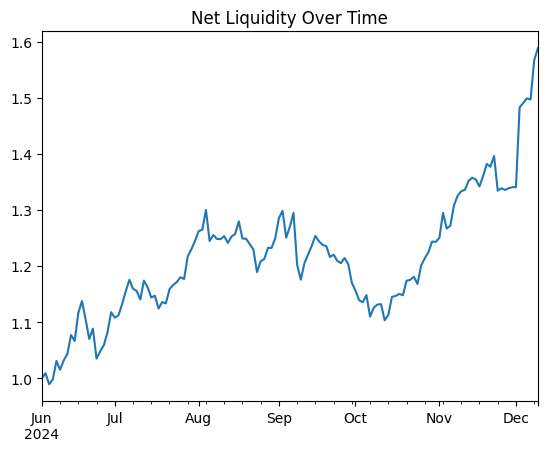

In [26]:
pd.Series( net_liqs ).plot(title="Net Liquidity Over Time")

<Axes: title={'center': 'net meta model'}>

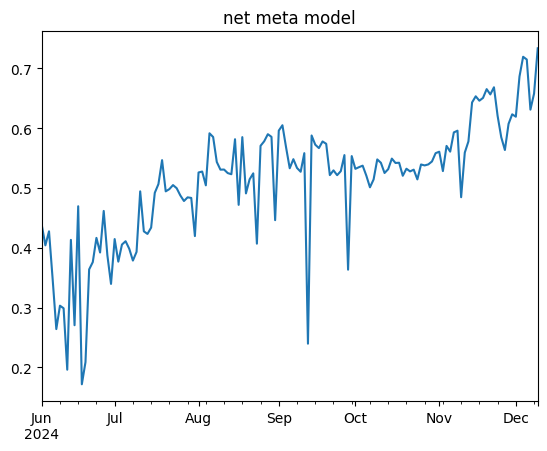

In [30]:
pd.Series( risks['meta_model'] ).plot(title="net meta model")

<Axes: title={'center': 'Dollar Weight'}>

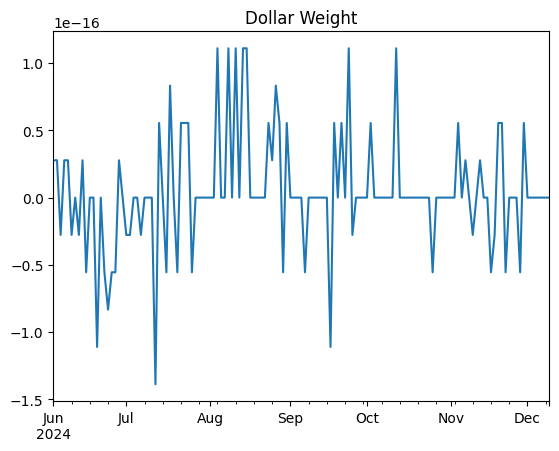

In [32]:
pd.Series( risks['dollars'] ).plot(title='Dollar Weight')

In [29]:
# Check how many symbols we have saved data for
for dat in dates:  # Print last 5 transactions
    print( dat, len( os.listdir(f'hl_data/{dat}/22') ) )

20240603 132
20240604 132
20240605 132
20240606 132
20240607 132
20240610 132
20240611 133
20240612 135
20240613 135
20240614 135
20240617 135
20240618 135
20240619 135
20240620 135
20240621 135
20240624 135
20240625 135
20240626 136
20240627 136
20240628 132
20240701 132
20240702 132
20240703 132
20240704 132
20240705 132
20240708 132
20240709 132
20240710 132
20240711 132
20240712 132
20240715 132
20240716 132
20240717 132
20240718 132
20240719 132
20240722 131
20240723 132
20240724 132
20240725 132
20240726 132
20240729 132
20240730 132
20240731 133
20240801 133
20240802 133
20240805 133
20240806 133
20240807 133
20240808 133
20240809 133
20240812 133
20240813 132
20240814 132
20240815 132
20240816 132
20240819 132
20240820 132
20240821 132
20240822 132
20240823 132
20240826 132
20240827 132
20240828 132
20240829 132
20240830 132
20240902 132
20240903 133
20240904 133
20240905 133
20240906 133
20240909 132
20240910 132
20240911 132
20240912 132
20240913 132
20240916 132
20240917 133

In [15]:
x = pd.DataFrame( portfolio_result.history )
x

,timestamp,symbol,shares,price
0,20240603,AAVE,0.0,101.81000
1,20240603,ADA,0.0,0.45928
2,20240603,APE,0.0,1.30790
3,20240603,APT,0.0,8.94890
4,20240603,AR,0.0,43.06400
...,...,...,...,...
12224,20241210,XLM,0.0,0.43016
12225,20241210,XRP,0.0,2.33600
12226,20241210,YGG,0.0,0.65198
12227,20241210,ZEN,0.0,13.61900


In [21]:
len( [ y for y in list( dex.universe.index ) if y in oracle.mm['symbol'].unique() ] )

105